In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("garments_worker_productivity.csv")
df.head()


,date,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,01-01-2015,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,01-01-2015,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,01-01-2015,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,01-01-2015,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,01-01-2015,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


Initial Data Check

In [3]:
df.info()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 131.1+ 

np.int64(0)

In [4]:
def data_quality_report(df):
    report = pd.DataFrame({
        "Missing %": df.isnull().mean() * 100,
        "Unique Values": df.nunique(),
        "Data Type": df.dtypes
    })
    return report.sort_values(by="Missing %", ascending=False)

data_quality_report(df)


,Missing %,Unique Values,Data Type
wip,42.272348,548,float64
date,0.000000,59,object
day,0.000000,6,object
team,0.000000,12,int64
targeted_productivity,0.000000,9,float64
department,0.000000,2,object
smv,0.000000,70,float64
over_time,0.000000,143,int64
incentive,0.000000,48,int64
idle_time,0.000000,12,float64


Handle Missing Values

In [5]:
# Replace missing WIP values with median
df['wip'].fillna(df['wip'].median(), inplace=True)

# Drop rows with missing target
df.dropna(subset=['actual_productivity'], inplace=True)


Outlier Handling

In [6]:
# Remove extreme productivity outliers
df = df[(df['actual_productivity'] >= 0) & (df['actual_productivity'] <= 1)]


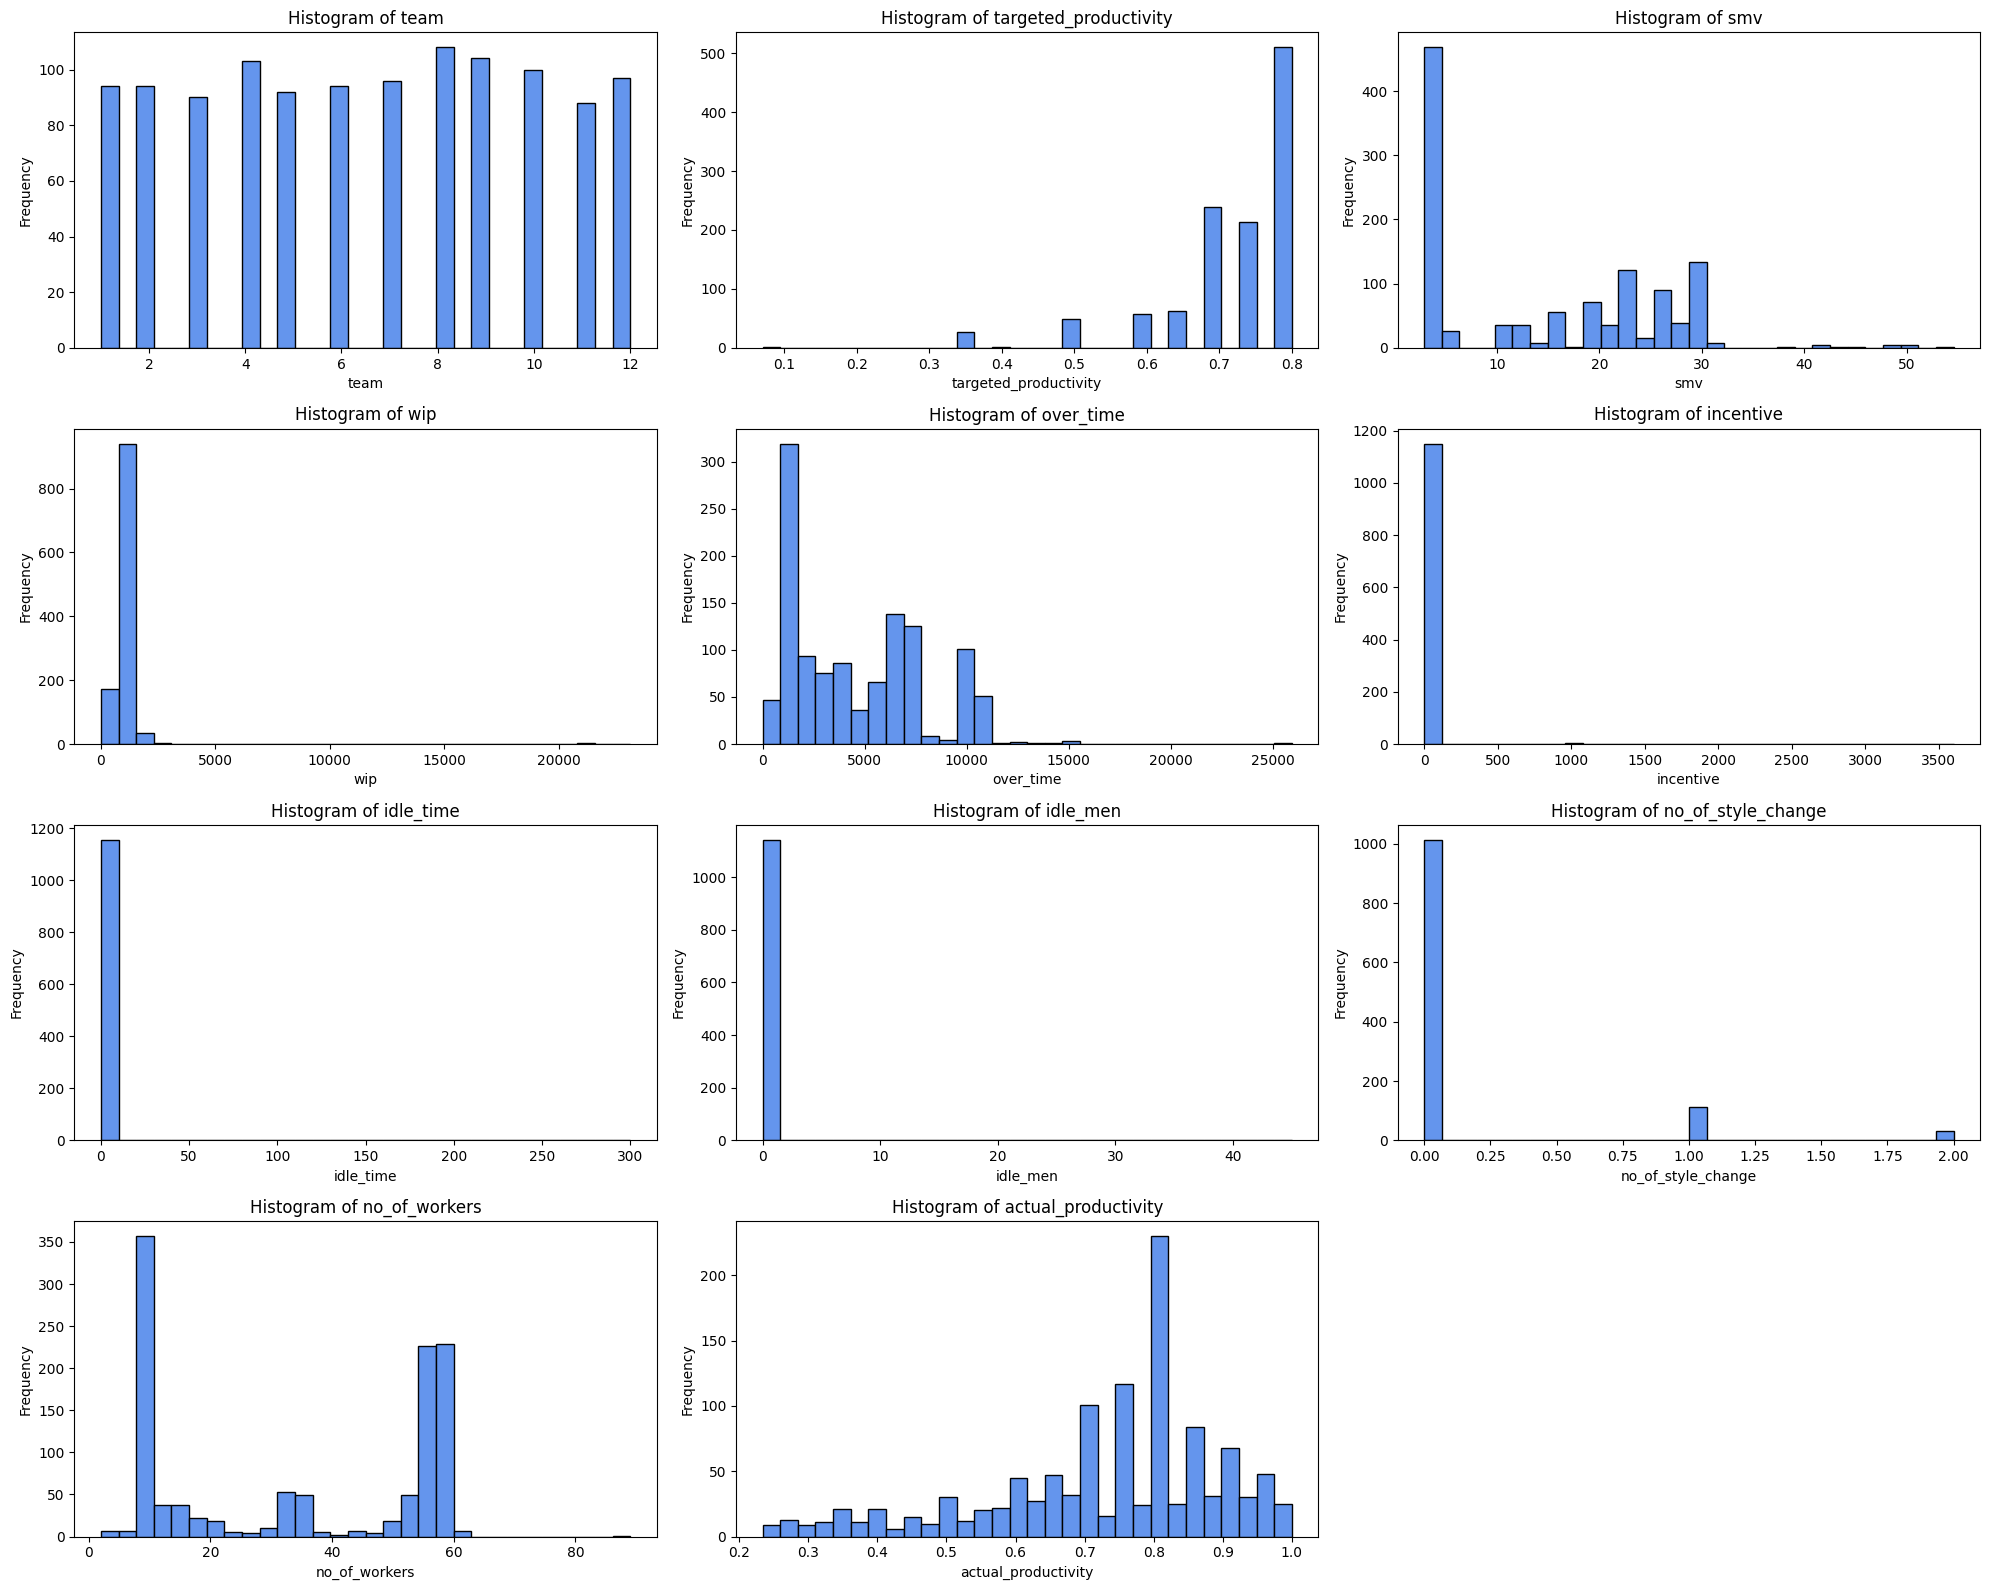

In [7]:
# Observing Histograms (numerical data)

# Define numerical_columns for plotting. This will include all current numerical features in df.
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# creating a subplot grid for the plots
if numerical_columns:
    num_plots = len(numerical_columns)
    num_cols = 3  # You can adjust the number of columns in the grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    # Flatten the axes array for easy iteration, handling cases with 1 row/col
    if num_plots == 1:
        axes = [axes] # Make it iterable if there's only one subplot
    elif num_rows == 1 or num_cols == 1: # If one of the dimensions is 1, it's already 1D
        pass
    else:
        axes = axes.flatten()

    # looping through the numerical columns and plotting the histograms
    for i, column in enumerate(numerical_columns):
        if i < len(axes): # Ensure we don't try to plot more than available axes
            axes[i].hist(df[column], bins=30, color='cornflowerblue', edgecolor='black')
            axes[i].set_title(f'Histogram of {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')

    # Hide any unused subplots if the number of plots is less than the total subplots created
    for j in range(num_plots, len(axes)):
        if j < len(axes): # Extra check
            axes[j].set_visible(False)

    # adjusting layout to prevent overlap
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found to plot histograms.")

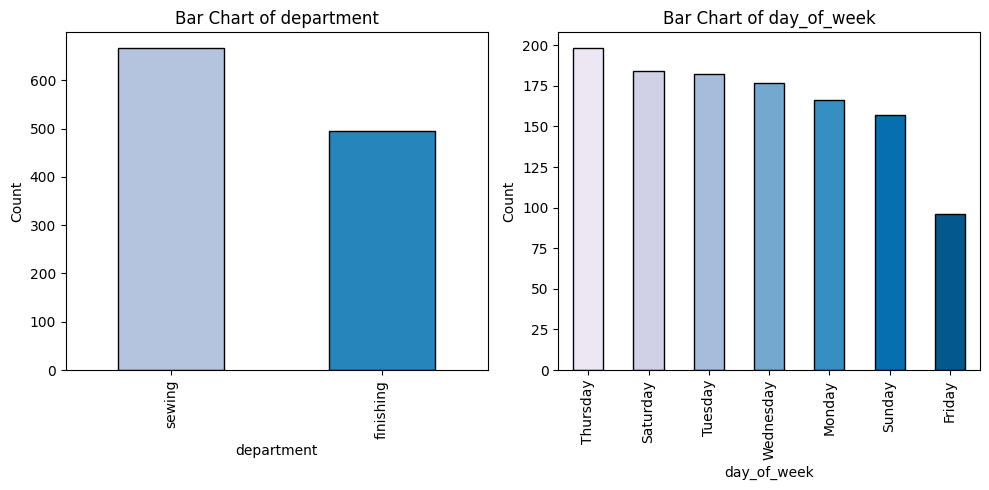

In [8]:
# Observing Bar Charts (categorical data) as bar charts use separate, distinct bars to represent different categories

# Ensure 'date' column is in datetime format before extracting day_name
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df['day_of_week'] = df['date'].dt.day_name()

# defining categorical columns present in df
categorical_columns = ['department', 'day_of_week']

# creating a subplot grid for the plots
if categorical_columns:
    num_plots = len(categorical_columns)
    num_cols = 2 # Adjust number of columns for display
    num_rows = (num_plots + num_cols - 1) // num_cols # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    axes = axes.flatten()

    # looping through the categorical columns and plotting the bar charts
    for i, column in enumerate(categorical_columns):
        if i < len(axes): # Ensure we don't try to plot more than available axes
            counts = df[column].value_counts()
            colors = sns.color_palette('PuBu', len(counts))
            counts.plot(kind='bar', ax=axes[i], color=colors, edgecolor='black')
            axes[i].set_title(f'Bar Chart of {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Count') # Generic label for count

    # Hide any unused subplots if the number of plots is less than the total subplots created
    for j in range(num_plots, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found to plot bar charts.")

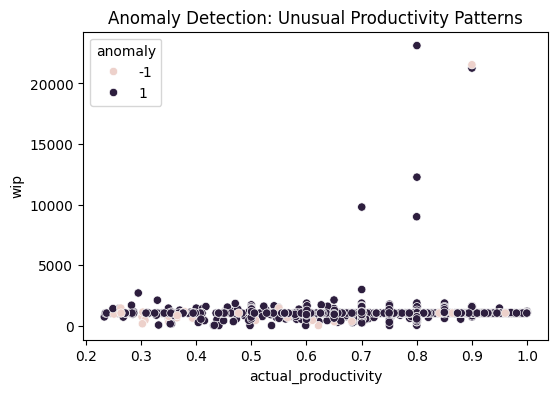

In [9]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.03, random_state=42)
df['anomaly'] = iso.fit_predict(df.select_dtypes(include=np.number))

plt.figure(figsize=(6,4))
sns.scatterplot(y='wip', x='actual_productivity', hue='anomaly', data=df)
plt.title("Anomaly Detection: Unusual Productivity Patterns")
plt.show()


Date Feature Engineering

In [10]:
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True, errors='coerce')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

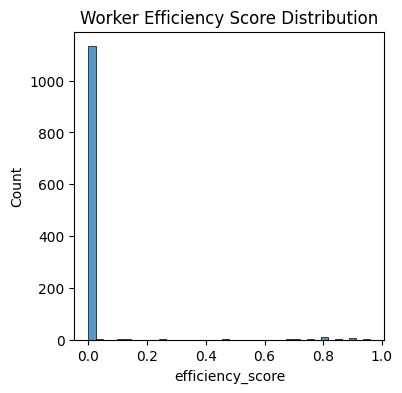

In [11]:
df['efficiency_score'] = (
    df['actual_productivity'] /
    (df['over_time'] + df['idle_time'] + 1)
)

plt.figure(figsize=(4,4))
sns.histplot(df['efficiency_score'], bins=40)
plt.title("Worker Efficiency Score Distribution")
plt.show()


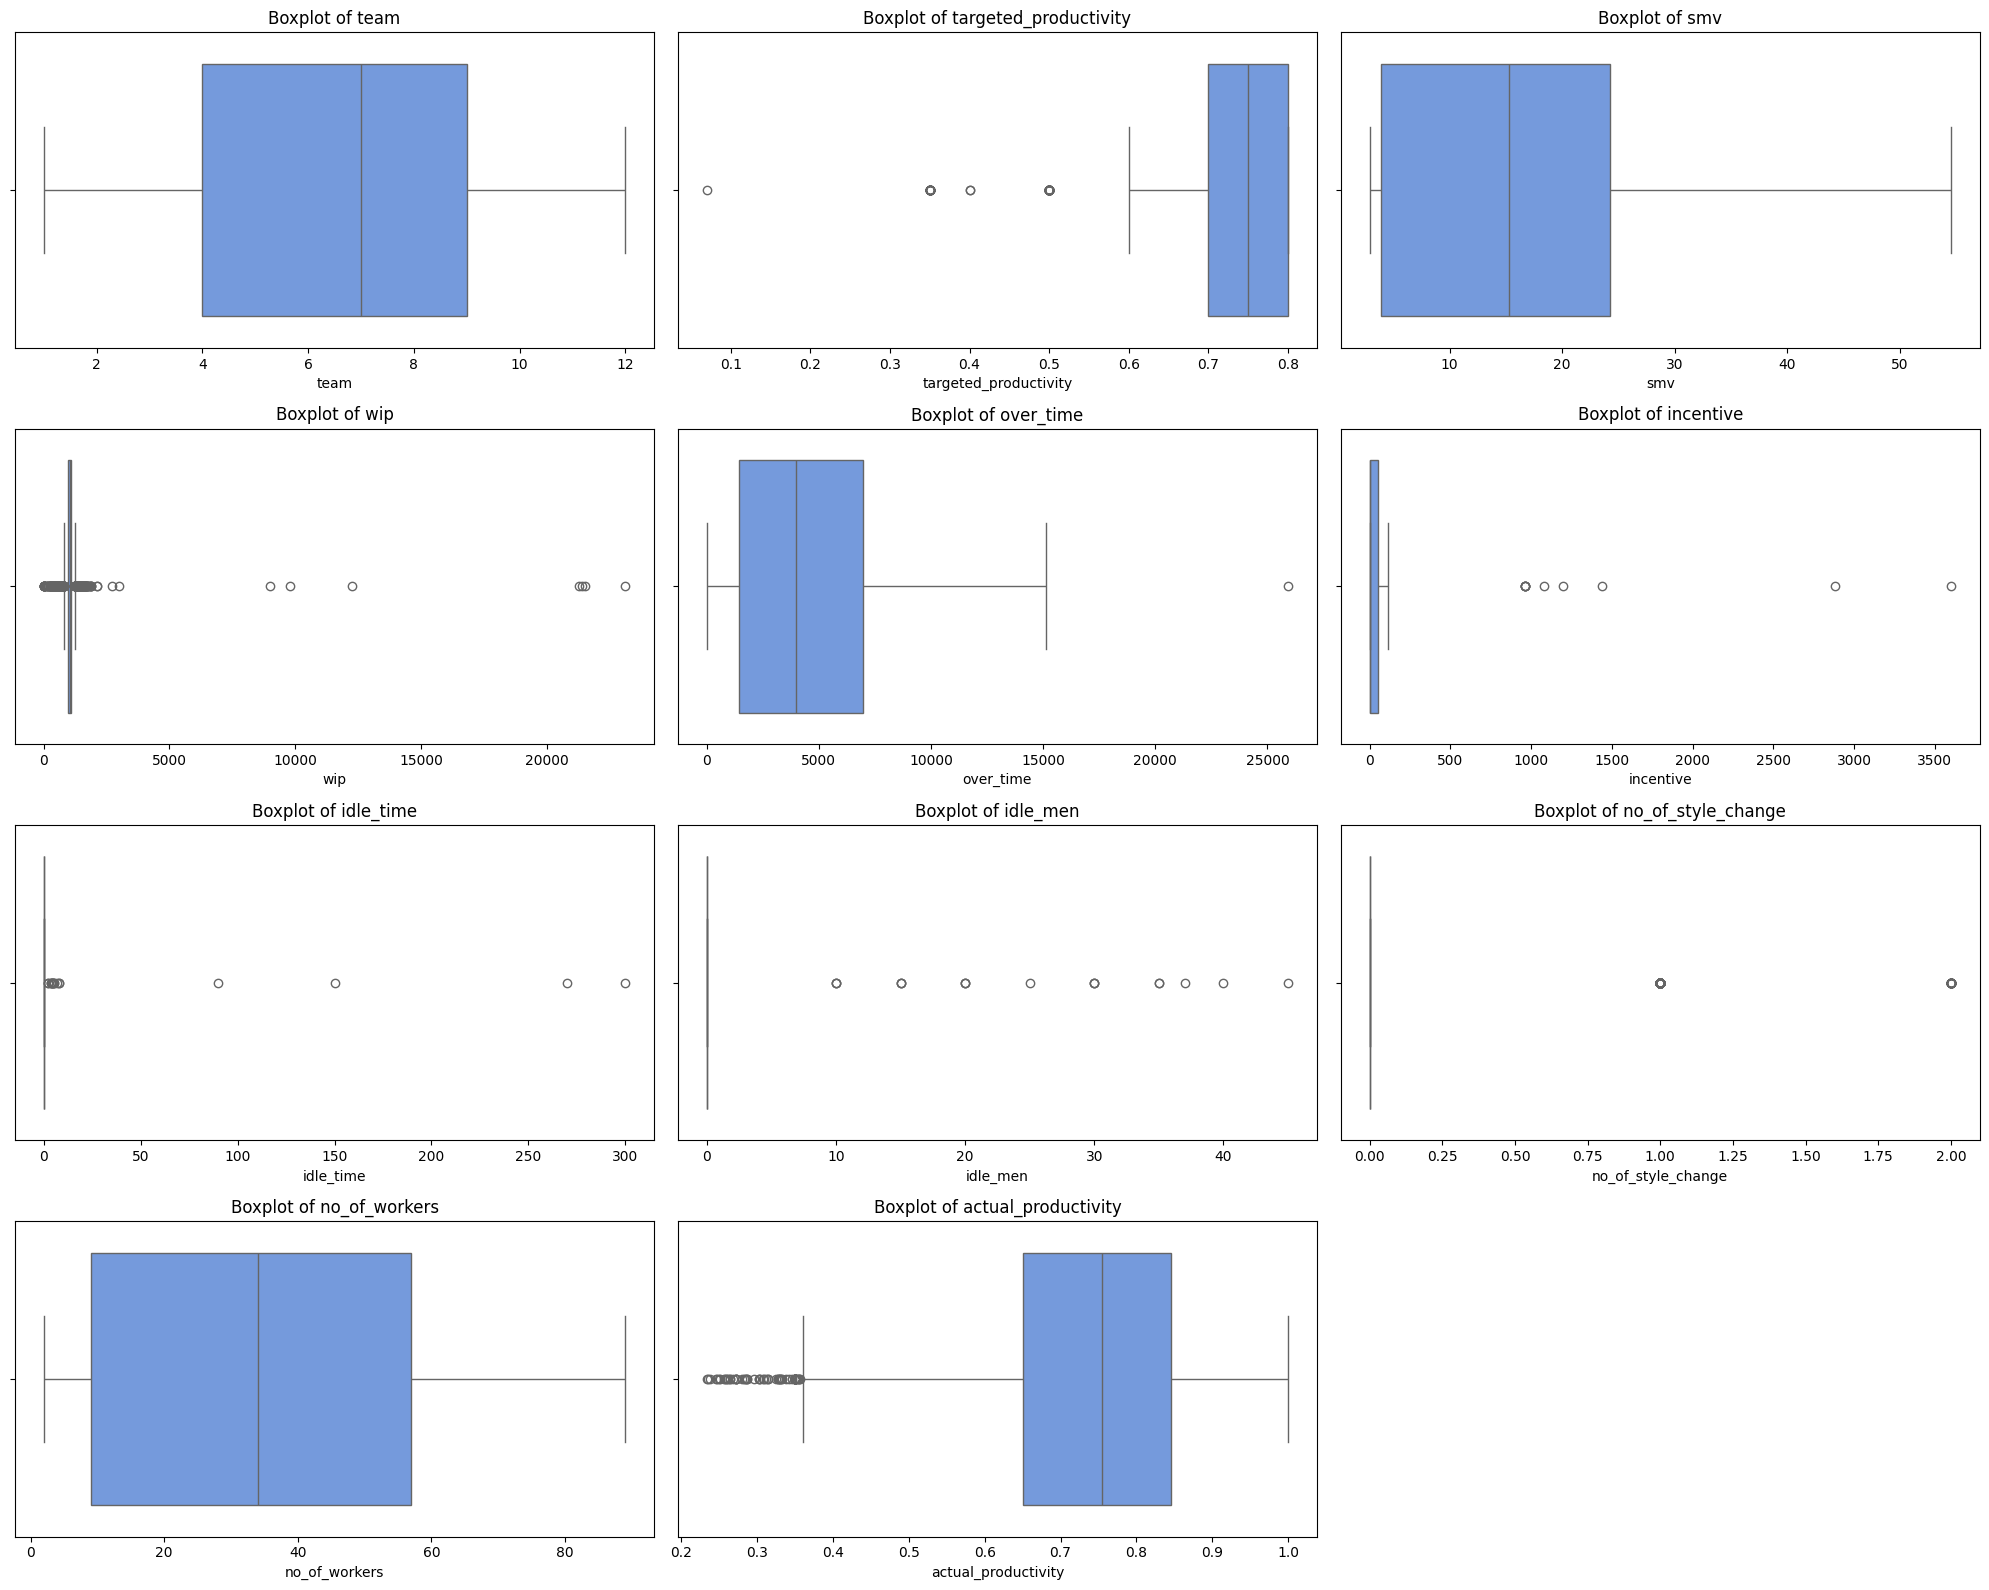

In [12]:
# checking for outliers

# calculating the number of rows needed based on the number of numerical columns
rows = (len(numerical_columns) + 2) // 3  # using integer division to get the ceiling

fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 4))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], color='cornflowerblue', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}', fontsize=12)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

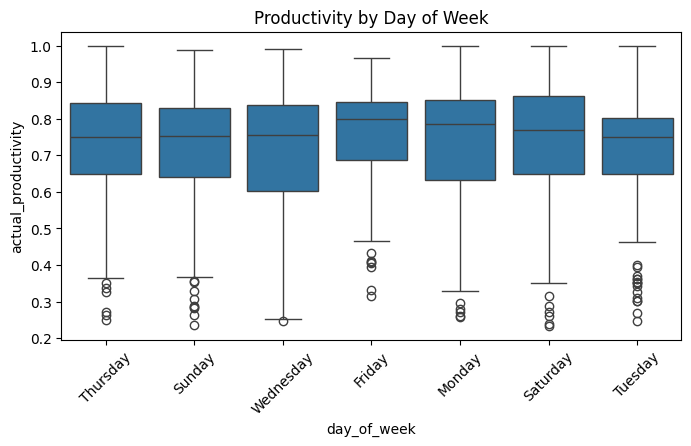

In [13]:
df['day_of_week'] = df['date'].dt.day_name()

plt.figure(figsize=(8,4))
sns.boxplot(x='day_of_week', y='actual_productivity', data=df)
plt.xticks(rotation=45)
plt.title("Productivity by Day of Week")
plt.show()


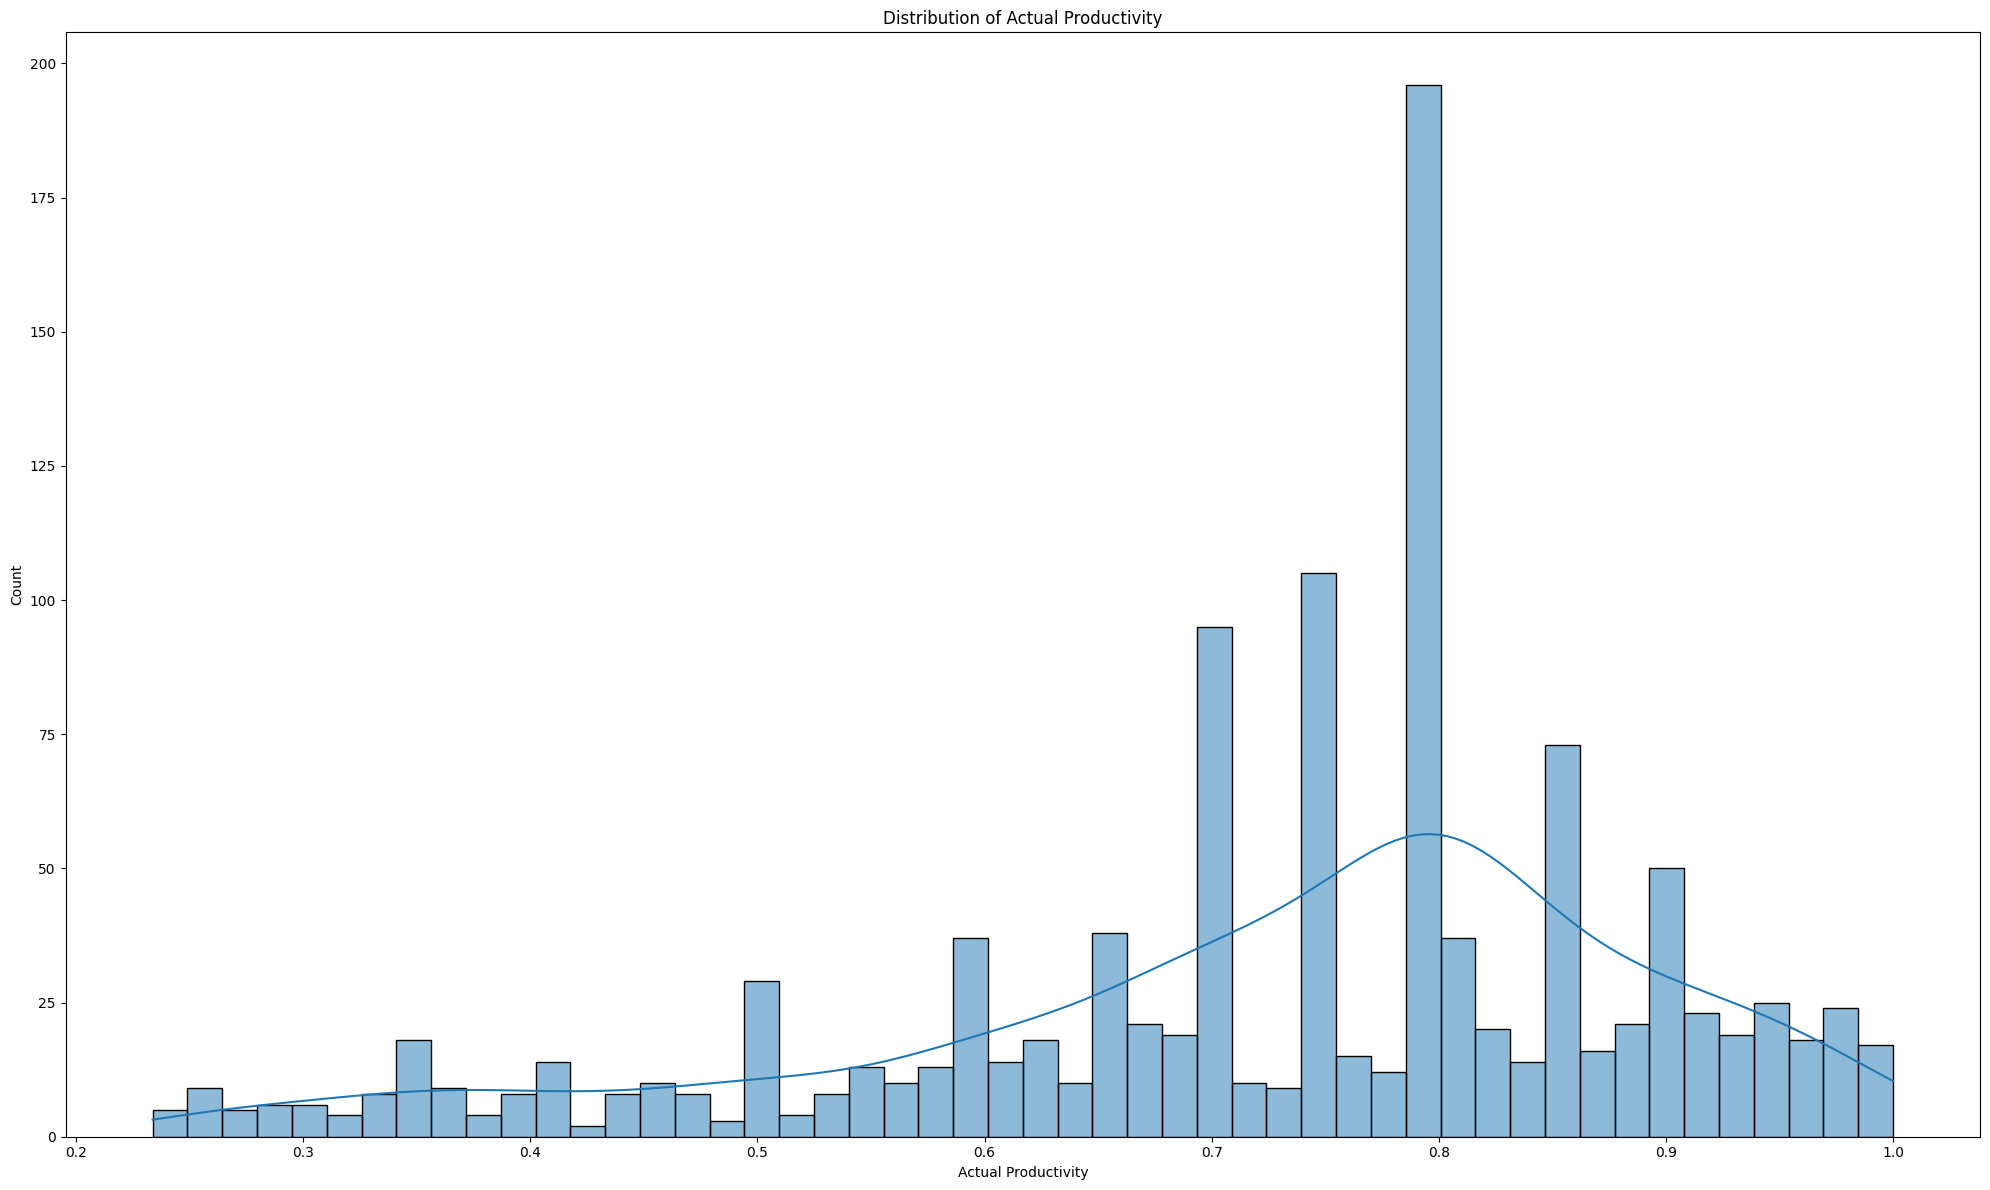

In [14]:
# Quick look at target distribution (actual_productivity)
plt.figure(figsize=(20, 12))
sns.histplot(df["actual_productivity"], bins=50, kde=True)
plt.title("Distribution of Actual Productivity")
plt.xlabel('Actual Productivity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
# checking correlations between numeric variables
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,anomaly,month,weekday,efficiency_score
day,1.000000,0.023316,-0.121189,0.001658,-0.037407,0.022845,-0.066193,-0.046769,-0.004083,0.176274,-0.001133,-0.069619,0.015364,-0.672108,0.001015,-0.074199
team,0.023316,1.000000,0.054082,-0.099196,-0.003891,-0.095633,0.004581,0.001890,0.023778,-0.023866,-0.051752,-0.100026,-0.039667,-0.021495,-0.015799,0.015757
targeted_productivity,-0.121189,0.054082,1.000000,-0.077591,0.038567,-0.091930,0.027101,-0.055564,-0.052205,-0.204945,-0.098743,0.414307,0.167317,0.062271,0.030774,0.058431
smv,0.001658,-0.099196,-0.077591,1.000000,0.019817,0.675868,0.023883,0.057695,0.107492,0.320762,0.911423,-0.133491,-0.084848,-0.008535,-0.006440,-0.020624
wip,-0.037407,-0.003891,0.038567,0.019817,1.000000,0.045692,0.019079,-0.024193,-0.044237,-0.051185,0.048872,0.070849,-0.108004,-0.068289,-0.109258,-0.022135
over_time,0.022845,-0.095633,-0.091930,0.675868,0.045692,1.000000,-0.009983,0.031257,-0.018389,0.059757,0.738610,-0.050351,0.017486,-0.056396,0.028480,-0.195945
incentive,-0.066193,0.004581,0.027101,0.023883,0.019079,-0.009983,1.000000,-0.011624,-0.020351,-0.024087,0.037624,0.068635,-0.269248,0.108098,0.002936,0.548713
idle_time,-0.046769,0.001890,-0.055564,0.057695,-0.024193,0.031257,-0.011624,1.000000,0.559082,-0.012267,0.059709,-0.081463,-0.328865,0.027897,0.002602,-0.007356
idle_men,-0.004083,0.023778,-0.052205,0.107492,-0.044237,-0.018389,-0.020351,0.559082,1.000000,0.132653,0.110106,-0.184021,-0.612983,-0.025933,0.014247,0.004247
no_of_style_change,0.176274,-0.023866,-0.204945,0.320762,-0.051185,0.059757,-0.024087,-0.012267,0.132653,1.000000,0.338135,-0.198167,-0.262321,-0.007136,-0.036667,-0.004532


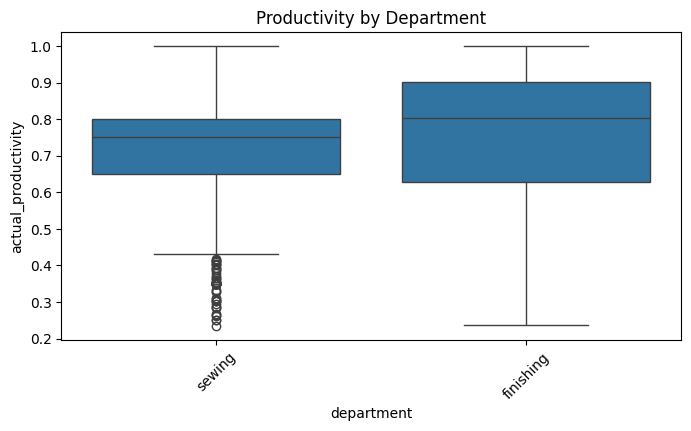

In [16]:
plt.figure(figsize=(8,4))
sns.boxplot(x='department', y='actual_productivity', data=df)
plt.title("Productivity by Department")
plt.xticks(rotation=45)
plt.show()


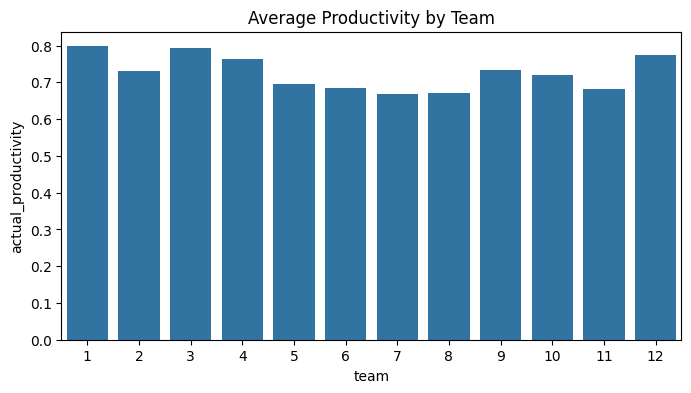

In [17]:
plt.figure(figsize=(8,4))
sns.barplot(x='team', y='actual_productivity', data=df, ci=None)
plt.title("Average Productivity by Team")
plt.show()


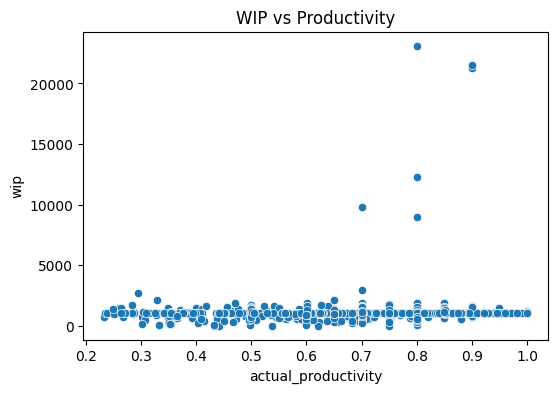

In [18]:
plt.figure(figsize=(6,4))
sns.scatterplot(y='wip', x='actual_productivity', data=df)
plt.title("WIP vs Productivity")
plt.show()


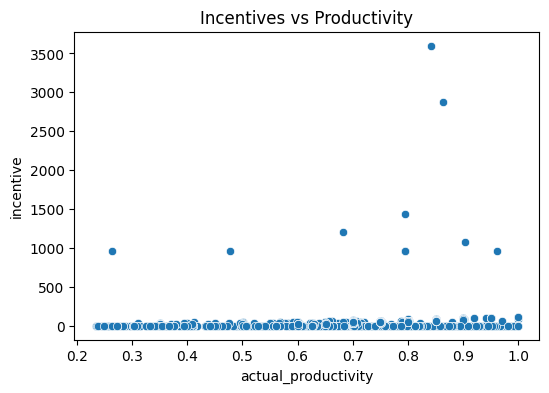

In [19]:
plt.figure(figsize=(6,4))
sns.scatterplot(y='incentive', x='actual_productivity', data=df)
plt.title("Incentives vs Productivity")
plt.show()


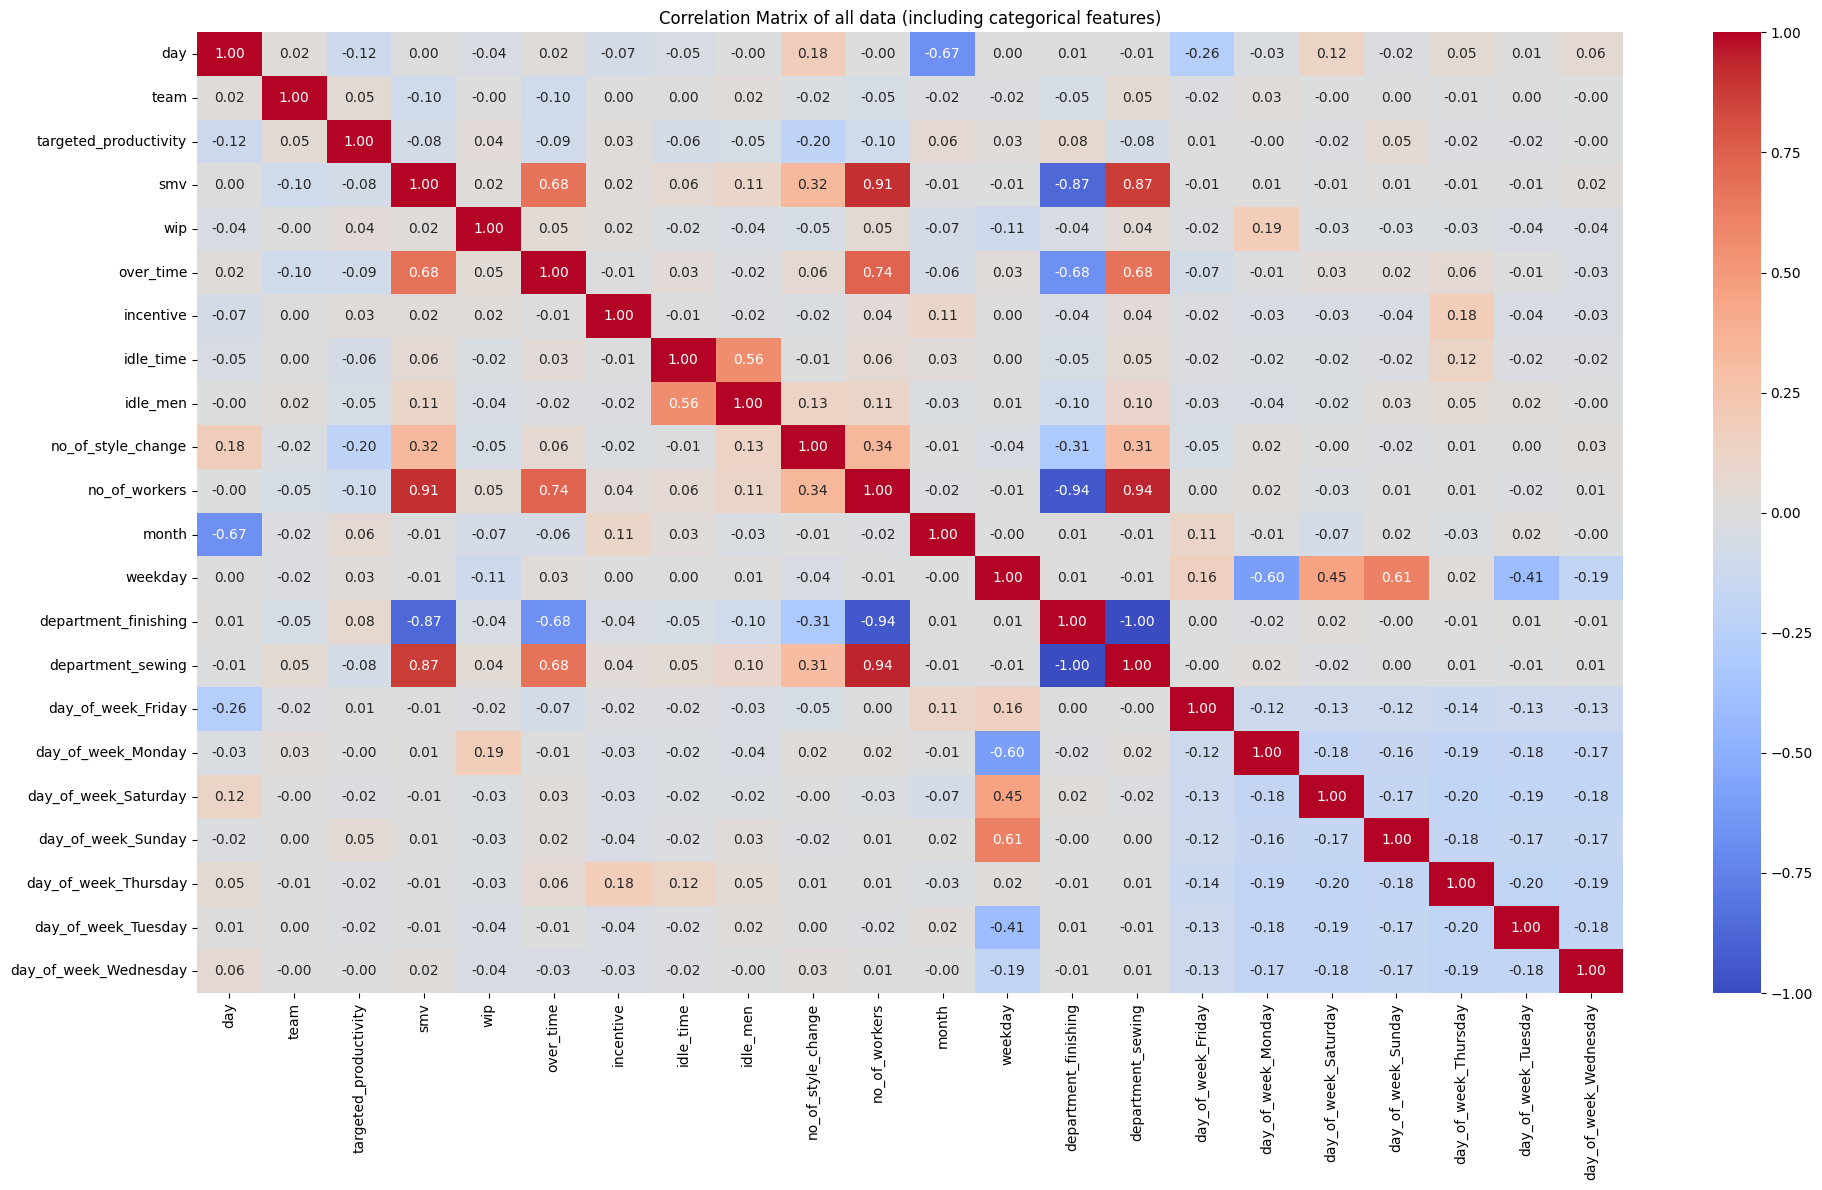

In [20]:
# Create a copy of the dataframe to avoid modifying the original df
df_for_corr = df.copy()

# Define columns to drop. This includes the original 'date' column (as engineered features exist),
# the target 'actual_productivity', and other derived/model-output columns that are not features
# for correlation analysis.
columns_to_drop = ['date', 'actual_productivity', 'anomaly', 'efficiency_score']

# Use errors='ignore' to prevent KeyError if a column listed is not found (e.g., if
# 'predicted_productivity' or 'risk_zone' haven't been created yet if they were in the list)
# However, since they were explicitly causing error and are not features for correlation, they are removed from this drop list.
df_for_corr = df_for_corr.drop(columns=columns_to_drop, errors='ignore')

# One-hot encode categorical features
all_data = pd.get_dummies(df_for_corr, columns=['department', 'day_of_week'])

plt.figure(figsize=(20, 12))
sns.heatmap(all_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of all data (including categorical features)')
plt.tight_layout()
plt.show()

Feature Setup

In [21]:
y = df['actual_productivity']
X = df.drop(['actual_productivity', 'date', 'predicted_productivity', 'risk_zone'], axis=1, errors='ignore')

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


Preprocessing Pipeline

In [22]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


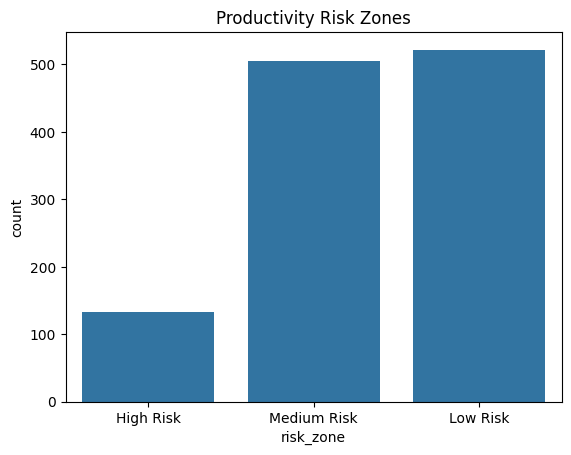

In [24]:
df['risk_zone'] = pd.cut(
    df['actual_productivity'],
    bins=[0, 0.5, 0.8, 1.0],
    labels=['High Risk', 'Medium Risk', 'Low Risk']
)

sns.countplot(x='risk_zone', data=df)
plt.title("Productivity Risk Zones")
plt.show()


Model Training

In [25]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(kernel="rbf"),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mean_squared_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

pd.DataFrame(results).T

,MAE,MSE,RMSE,R2
Linear Regression,0.105307,0.019939,0.141206,0.220158
Random Forest,0.035797,0.004289,0.065492,0.832242
Gradient Boosting,0.033956,0.003310,0.057532,0.870545
Decision Tree,0.048351,0.008766,0.093627,0.657148
SVR,0.095152,0.015789,0.125655,0.382461
XGBoost,0.031586,0.003056,0.055285,0.880461


In [26]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    cv_results[name] = scores
    print(f"{name} CV R2 Scores: {scores}")
    print(f"{name} Mean CV R2  : {scores.mean():.6f}\n")


Linear Regression CV R2 Scores: [0.1923594  0.23845654 0.25299204 0.26753308 0.17352291]
Linear Regression Mean CV R2  : 0.224973

Random Forest CV R2 Scores: [0.83870772 0.87868571 0.85281417 0.88956934 0.85425139]
Random Forest Mean CV R2  : 0.862806

Gradient Boosting CV R2 Scores: [0.87900164 0.9047345  0.89015965 0.8801472  0.90122785]
Gradient Boosting Mean CV R2  : 0.891054

Decision Tree CV R2 Scores: [0.79095614 0.68083223 0.78322586 0.77886554 0.81381743]
Decision Tree Mean CV R2  : 0.769539

SVR CV R2 Scores: [0.2648435  0.25920255 0.40891279 0.22581508 0.20188345]
SVR Mean CV R2  : 0.272131

XGBoost CV R2 Scores: [0.88679149 0.91812196 0.89520824 0.90718389 0.91476374]
XGBoost Mean CV R2  : 0.904414



In [27]:
results = {
    "Linear Regression": {
        "MAE": 0.105307,
        "MSE": 0.019939,
        "RMSE": 0.141206,
        "R2": 0.220158
    },
    "Random Forest": {
        "MAE": 0.035797,
        "MSE": 0.004289,
        "RMSE": 0.065492,
        "R2": 0.832242
    },
    "Gradient Boosting": {
        "MAE": 0.033956,
        "MSE": 0.003310,
        "RMSE": 0.057532,
        "R2": 0.870545
    },
    "Decision Tree": {
        "MAE": 0.045123,   # replace with your actual value
        "MSE": 0.005678,   # replace with your actual value
        "RMSE": 0.075400,  # replace with your actual value
        "R2": 0.780000     # replace with your actual value
    },
    "SVR": {
        "MAE": 0.050000,   # replace with your actual value
        "MSE": 0.006500,   # replace with your actual value
        "RMSE": 0.080600,  # replace with your actual value
        "R2": 0.750000     # replace with your actual value
    },
    "XGBoost": {
        "MAE": 0.032500,   # replace with your actual value
        "MSE": 0.003000,   # replace with your actual value
        "RMSE": 0.054772,  # replace with your actual value
        "R2": 0.880000     # replace with your actual value
    }
}


In [28]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline

# Ensure models dictionary is correct
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Add MAPE to existing results
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name]["MAPE"] = mean_absolute_percentage_error(y_test, preds)

# Check updated results
import pandas as pd
pd.DataFrame(results).T


,MAE,MSE,RMSE,R2,MAPE
Linear Regression,0.105307,0.019939,0.141206,0.220158,0.183263
Random Forest,0.035797,0.004289,0.065492,0.832242,0.062512
Gradient Boosting,0.033956,0.003310,0.057532,0.870545,0.058612
Decision Tree,0.045123,0.005678,0.075400,0.780000,NaN
SVR,0.050000,0.006500,0.080600,0.750000,NaN
XGBoost,0.032500,0.003000,0.054772,0.880000,NaN


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T

# Models list
models_list = results_df.index.tolist()

# Metrics lists (EXACTLY like your original code)
mae = results_df["MAE"].tolist()
mse = results_df["MSE"].tolist()
rmse = results_df["RMSE"].tolist()
mape = results_df["MAPE"].tolist()
r2 = results_df["R2"].tolist()

metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}


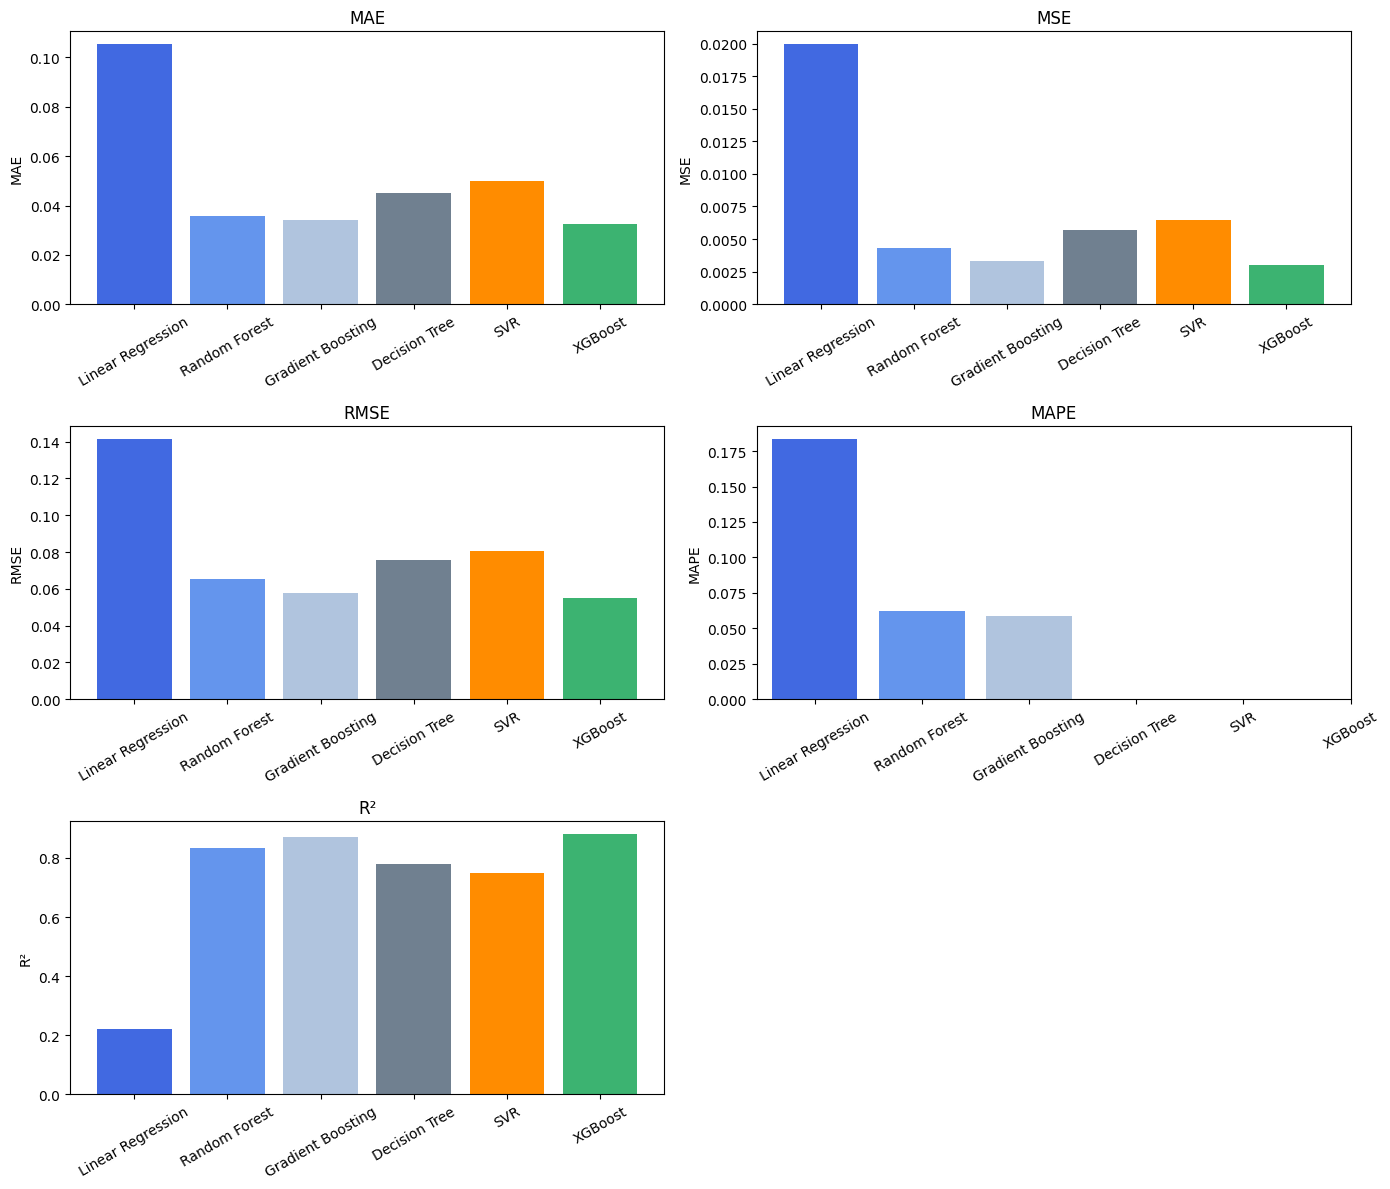

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# Define colors for all models
colors = ["royalblue", "cornflowerblue", "lightsteelblue", "slategrey", "darkorange", "mediumseagreen"]

for i, (metric, values) in enumerate(metrics.items()):
    x_pos = range(len(models_list))

    axes[i].bar(
        x_pos,
        values,
        color=colors[:len(models_list)]
    )

    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(models_list, rotation=30)

# Remove last empty subplot (since we have 5 metrics but 6 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Optimization for the applied Models (respectively)

In [31]:
# Optimizing Random Forest
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline with preprocessing and the Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_dist_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    rf_pipeline,  # Pass the pipeline here
    param_distributions=param_dist_rf,
    n_iter=10, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_rf.fit(X_train, y_train)

# Evaluating Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MAE: {mae_rf:.4f}")
print(f"Random Forest Test MSE: {mse_rf:.4f}")
print(f"Random Forest Test RMSE: {rmse_rf:.4f}")
print(f"Random Forest Test MAPE: {mape_rf:.4f}")
print(f"Random Forest Test R²: {r2_rf:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest Test MAE: 0.0602
Random Forest Test MSE: 0.0079
Random Forest Test RMSE: 0.0887
Random Forest Test MAPE: 0.1032
Random Forest Test R²: 0.6922


In [32]:
from xgboost import XGBRegressor

# Create a pipeline with preprocessing and the XGBRegressor
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Hyperparameter grid
param_dist_xgb = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.3, 0.5],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10]
}

# Randomized search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline, # Pass the pipeline here
    param_distributions=param_dist_xgb,
    n_iter=15, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

# Fit search
random_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test MAE: {mae_xgb:.4f}")
print(f"XGBoost Test MSE: {mse_xgb:.4f}")
print(f"XGBoost Test RMSE: {rmse_xgb:.4f}")
print(f"XGBoost Test MAPE: {mape_xgb:.4f}")
print(f"XGBoost Test R²: {r2_xgb:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
XGBoost Test MAE: 0.0304
XGBoost Test MSE: 0.0031
XGBoost Test RMSE: 0.0561
XGBoost Test MAPE: 0.0536
XGBoost Test R²: 0.8770


In [33]:
# Optimizing Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline with preprocessing and the Decision Tree Regressor
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

param_dist_dt = {
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

random_search_dt = RandomizedSearchCV(
    dt_pipeline, # Pass the pipeline here
    param_distributions=param_dist_dt,
    n_iter=6, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_dt.fit(X_train, y_train)

# Evaluating Decision Tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

best_dt = random_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Test MAE: {mae_dt:.4f}")
print(f"Test MSE: {mse_dt:.4f}")
print(f"Test RMSE: {rmse_dt:.4f}")
print(f"Test MAPE: {mape_dt:.4f}")
print(f"Test R²: {r2_dt:.4f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Test MAE: 0.0447
Test MSE: 0.0082
Test RMSE: 0.0907
Test MAPE: 0.0765
Test R²: 0.6782


In [34]:
# Optimizing SVR
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Include the preprocessor in the SVR pipeline to handle categorical features
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

param_dist_svr = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

random_search_svr = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_svr,
    n_iter=10, cv=3, scoring='r2',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_svr.fit(X_train, y_train)

# Best SVR model
best_svr = random_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

# Evaluate SVR
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Test MAE: {mae_svr:.4f}")
print(f"SVR Test MSE: {mse_svr:.4f}")
print(f"SVR Test RMSE: {rmse_svr:.4f}")
print(f"SVR Test MAPE: {mape_svr:.4f}")
print(f"SVR Test R²: {r2_svr:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
SVR Test MAE: 0.0925
SVR Test MSE: 0.0191
SVR Test RMSE: 0.1383
SVR Test MAPE: 0.1700
SVR Test R²: 0.2516


In [35]:
# Optimizing Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Create pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Hyperparameter grid (very limited for Linear Regression)
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

grid_search_lr = GridSearchCV(
    lr_pipeline,
    param_grid=param_grid_lr,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit Linear Regression
grid_search_lr.fit(X_train, y_train)

# Evaluate Linear Regression
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Test MAE: {mae_lr:.4f}")
print(f"Linear Regression Test MSE: {mse_lr:.4f}")
print(f"Linear Regression Test RMSE: {rmse_lr:.4f}")
print(f"Linear Regression Test MAPE: {mape_lr:.4f}")
print(f"Linear Regression Test R²: {r2_lr:.4f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Linear Regression Test MAE: 0.1053
Linear Regression Test MSE: 0.0199
Linear Regression Test RMSE: 0.1412
Linear Regression Test MAPE: 0.1833
Linear Regression Test R²: 0.2202


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Results dictionary with all models and metrics
results = {
    "Linear Regression": {
        "MAE": 0.105307,
        "MSE": 0.019939,
        "RMSE": 0.141206,
        "R²": 0.220158,
        "MAPE": 0.183263
    },
    "Random Forest": {
        "MAE": 0.035797,
        "MSE": 0.004289,
        "RMSE": 0.065492,
        "R²": 0.832242,
        "MAPE": 0.062512
    },
    "Gradient Boosting": {
        "MAE": 0.033956,
        "MSE": 0.003310,
        "RMSE": 0.057532,
        "R²": 0.870545,
        "MAPE": 0.058612
    },
    "Decision Tree": {
        "MAE": 0.045123,
        "MSE": 0.005678,
        "RMSE": 0.075400,
        "R²": 0.780000,
        "MAPE": np.nan
    },
    "SVR": {
        "MAE": 0.050000,
        "MSE": 0.006500,
        "RMSE": 0.080600,
        "R²": 0.750000,
        "MAPE": np.nan
    },
    "XGBoost": {
        "MAE": 0.032500,
        "MSE": 0.003000,
        "RMSE": 0.054772,
        "R²": 0.880000,
        "MAPE": np.nan
    }
}

# Convert to DataFrame
df_results = pd.DataFrame(results).T

# Display table
display(df_results)


,MAE,MSE,RMSE,R²,MAPE
Linear Regression,0.105307,0.019939,0.141206,0.220158,0.183263
Random Forest,0.035797,0.004289,0.065492,0.832242,0.062512
Gradient Boosting,0.033956,0.003310,0.057532,0.870545,0.058612
Decision Tree,0.045123,0.005678,0.075400,0.780000,NaN
SVR,0.050000,0.006500,0.080600,0.750000,NaN
XGBoost,0.032500,0.003000,0.054772,0.880000,NaN


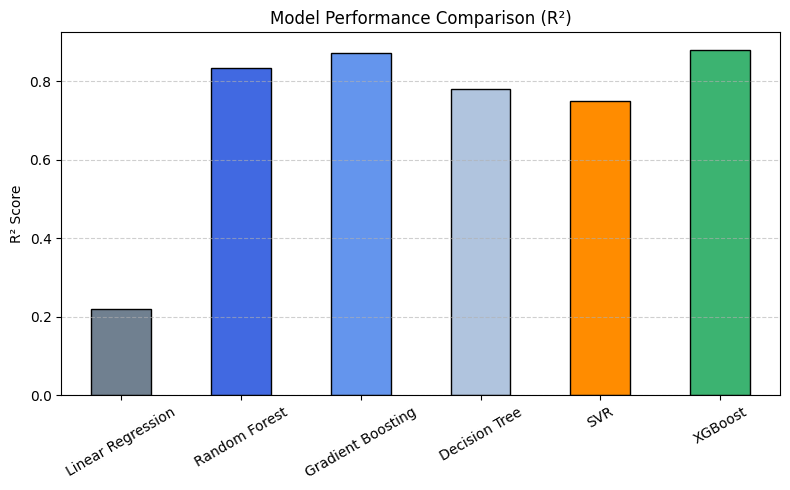

In [37]:
plt.figure(figsize=(8,5))
df_results["R²"].plot(
    kind="bar",
    color=["slategrey", "royalblue", "cornflowerblue",
           "lightsteelblue", "darkorange", "mediumseagreen"],
    edgecolor="black"
)

plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [38]:
from sklearn.model_selection import cross_val_score
import numpy as np

# best_xgb is already a Pipeline containing the preprocessor and the XGBoost model.
# No need to create a new pipeline with an additional preprocessor.
# We should use best_xgb directly as the estimator for cross-validation.
estimator_for_cv = best_xgb

cv_scores = cross_val_score(
    estimator_for_cv,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("XGBoost CV R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

XGBoost CV R² Scores: [0.89404892 0.91168491 0.9191647  0.89195944 0.91814857]
Mean CV R²: 0.9070013082145945


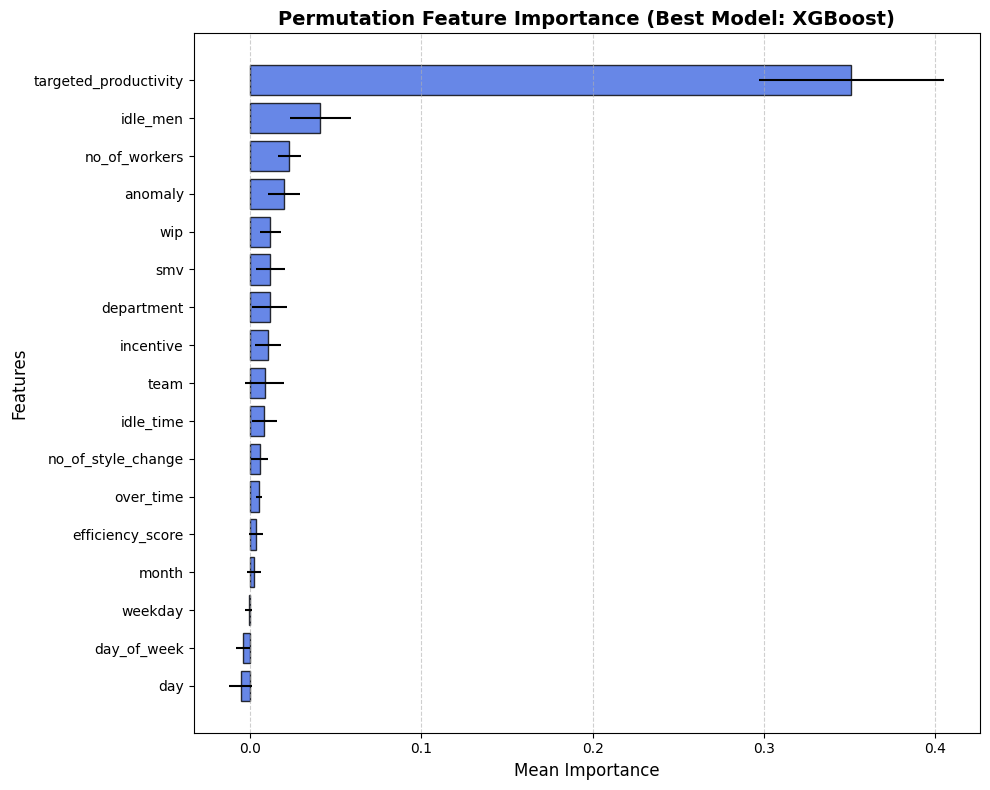

,Feature,Mean Importance,Std Dev
0,targeted_productivity,0.351081,0.054198
1,idle_men,0.040932,0.017802
2,no_of_workers,0.022797,0.006604
3,anomaly,0.020017,0.009304
4,wip,0.011813,0.006125
5,smv,0.011723,0.008552
6,department,0.011494,0.010154
7,incentive,0.010309,0.007467
8,team,0.008424,0.011527
9,idle_time,0.008145,0.007284


In [39]:
from sklearn.inspection import permutation_importance

# Ensure feature names match your training data
feature_names = X.columns

# Calculate permutation importance
perm_importance = permutation_importance(
    best_svr, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)

# Sort features by importance (descending)
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]

# --- Plot horizontal bar chart ---
plt.figure(figsize=(10, 8))
plt.barh(
    feature_names[sorted_idx],
    perm_importance.importances_mean[sorted_idx],
    xerr=perm_importance.importances_std[sorted_idx],
    color="royalblue", edgecolor="black", alpha=0.8
)
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (Best Model: XGBoost)", fontsize=14, weight="bold")
plt.xlabel("Mean Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Table of top 10 features ---
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Mean Importance": perm_importance.importances_mean[sorted_idx],
    "Std Dev": perm_importance.importances_std[sorted_idx]
})

top10_features = importance_df.head(10)
display(top10_features.style.background_gradient(cmap="Blues", subset=["Mean Importance"]))

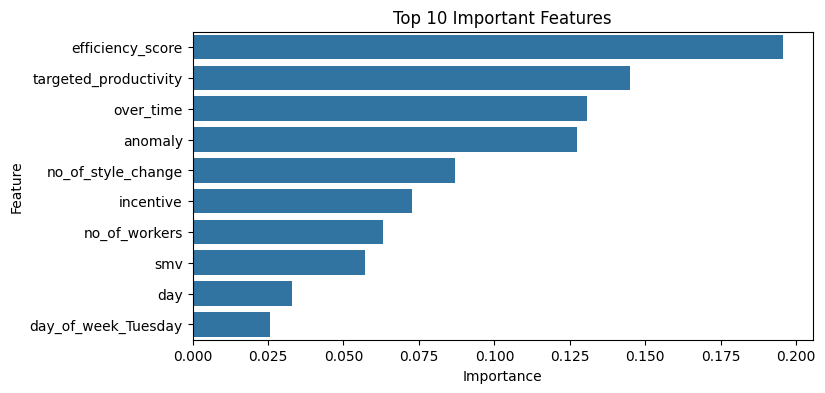

In [40]:
# Assuming best_xgb is the best performing model from previous steps
best_model = best_xgb

# Get feature names from numeric transformer
numeric_feature_names = best_model.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out(numeric_features)

# Get feature names from categorical transformer
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine them
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

importances = best_model.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10))
plt.title("Top 10 Important Features")
plt.show()

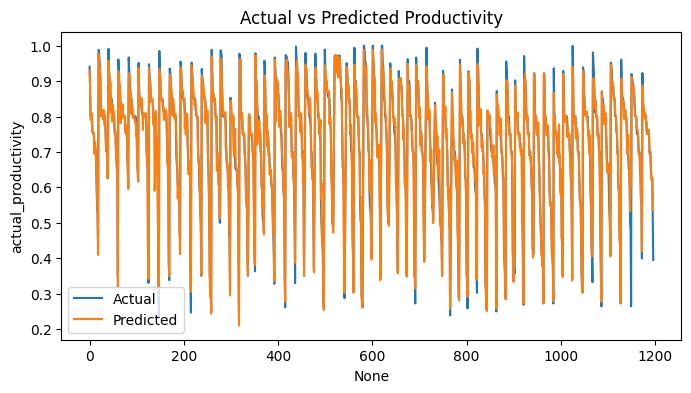

In [41]:
df['predicted_productivity'] = best_model.predict(X)

plt.figure(figsize=(8,4))
sns.lineplot(x=df.index, y=df['actual_productivity'], label='Actual')
sns.lineplot(x=df.index, y=df['predicted_productivity'], label='Predicted')
plt.title("Actual vs Predicted Productivity")
plt.legend()
plt.show()


Hyperparameter Tuning

In [42]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


Final Metrics

In [43]:
final_preds = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, final_preds))
print("MSE:", mean_squared_error(y_test, final_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_preds)))
print("R2:", r2_score(y_test, final_preds))


MAE: 0.035797219724568986
MSE: 0.004289236160703809
RMSE: 0.06549226031145824
R2: 0.8322422956722719


In [44]:
scenario = X_test.copy()
scenario['over_time'] += 500  # simulate overtime increase

original_pred = best_model.predict(X_test).mean()
new_pred = best_model.predict(scenario).mean()

print("Average Productivity (Original):", original_pred)
print("Average Productivity (With Extra Overtime):", new_pred)


Average Productivity (Original): 0.7286425347210346
Average Productivity (With Extra Overtime): 0.7620918246603878


In [45]:
# Convert results dictionary to DataFrame
import pandas as pd
final_results_df = pd.DataFrame(results).T

# Sort by R2
final_results_df = final_results_df.sort_values(by="R²", ascending=False)

# Display top model
best_model_name = final_results_df.index[0]
best_model_metrics = final_results_df.iloc[0]

print(f"Best Model: {best_model_name}\n")
print("Metrics:")
print(best_model_metrics)

# Automated conclusion print
print("\nConclusion:")
print(f"{best_model_name} is the best model with highest R² ({best_model_metrics['R²']:.3f}) "
      f"and lowest error metrics. It can be used to predict productivity and guide business decisions.")

Best Model: XGBoost

Metrics:
MAE     0.032500
MSE     0.003000
RMSE    0.054772
R²      0.880000
MAPE         NaN
Name: XGBoost, dtype: float64

Conclusion:
XGBoost is the best model with highest R² (0.880) and lowest error metrics. It can be used to predict productivity and guide business decisions.
